In [11]:

# 0) Imports & Config
import os, math, random
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List
from collections import Counter

np.set_printoptions(suppress=True, linewidth=140)

M=53; J=53; T=40; S=J*T
DIR_PATH="./raw"
PROB_EPS=1e-6; LOGIT_CLIP=7.0; STD_EPS=1e-12; SEED=0
rng=np.random.default_rng(SEED); random.seed(SEED)


In [12]:
def load_probs_labels_strict(dir_path: str, M: int, J: int):
    probs = {i: {} for i in range(1, M+1)}
    labels = {j: None for j in range(1, J+1)}
    accuracy = {i: {j: None for j in range(1, J+1)} for i in range(1, M+1)}
    any_found = False

    for i in range(1, M+1):
        for j in range(1, J+1):
            f = os.path.join(dir_path, f"src_{i:03d}", "probs", f"tgt_{j:03d}.csv")
            if not os.path.exists(f):
                continue
            df = pd.read_csv(f)
            if "p_A" not in df.columns or "label_num" not in df.columns:
                raise ValueError(f"{f}: columns p_A,label_num required")

            p = df["pred_str"].to_numpy()
            q = df["label_str"].to_numpy()

            if labels[j] is None:
                labels[j] = q
            else:
                if labels[j].shape != q.shape or not np.array_equal(labels[j], q):
                    raise ValueError(f"Label mismatch for client {j}: {f}")

            # True/False count
            accuracy[i][j] = np.sum(p == q)/40
            any_found = True

    if not any_found:
        raise RuntimeError("No files found under ./raw/...")

    return accuracy

In [13]:
accuracy = load_probs_labels_strict(DIR_PATH, M, J)

In [14]:
T_matrix = np.zeros((M, J))  # 모델 x 클라이언트 크기의 행렬


for i in range(1, M+1):
    for j in range(1, J+1):
        T_matrix[i-1, j-1] = accuracy[i][j] 

In [15]:
print(T_matrix)


for i in range(0, M):
    f=0
    for j in range(0, J):
        if T_matrix[j, i] >= T_matrix[i][i]:
            f+=1
    print(f)

[[0.775 0.55  0.5   ... 0.625 0.625 0.575]
 [0.45  0.65  0.425 ... 0.425 0.475 0.55 ]
 [0.45  0.45  0.6   ... 0.45  0.525 0.45 ]
 ...
 [0.6   0.575 0.65  ... 0.8   0.525 0.6  ]
 [0.675 0.475 0.45  ... 0.65  0.75  0.7  ]
 [0.7   0.5   0.575 ... 0.675 0.675 0.65 ]]
2
3
6
13
1
1
11
11
1
1
14
7
1
7
7
8
9
2
1
1
3
1
1
3
3
1
13
1
1
3
5
7
4
3
3
12
4
5
4
4
1
1
1
5
1
3
2
2
1
4
1
2
9


In [16]:
print(T_matrix)

for j in range(0, J):
    f=0
    for i in range(0, M):
        if T_matrix[j, i] >= T_matrix[i][i]:
            f+=1
    print(f)

[[0.775 0.55  0.5   ... 0.625 0.625 0.575]
 [0.45  0.65  0.425 ... 0.425 0.475 0.55 ]
 [0.45  0.45  0.6   ... 0.45  0.525 0.45 ]
 ...
 [0.6   0.575 0.65  ... 0.8   0.525 0.6  ]
 [0.675 0.475 0.45  ... 0.65  0.75  0.7  ]
 [0.7   0.5   0.575 ... 0.675 0.675 0.65 ]]
4
1
3
2
2
4
5
1
5
4
1
4
8
9
2
3
5
7
8
2
3
3
3
2
4
4
4
5
4
4
2
3
4
4
3
2
2
9
1
3
1
3
9
4
4
6
7
1
12
2
5
10
8


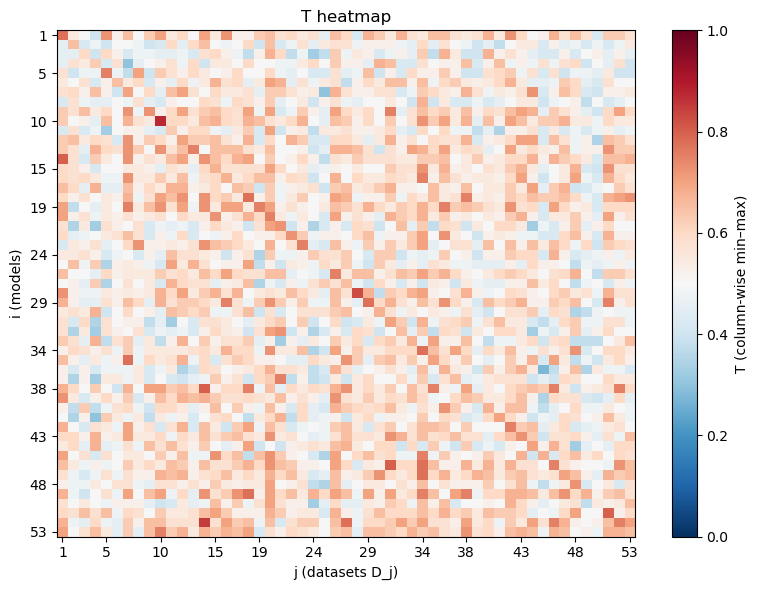

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_heatmap_T(
    T_matrix,
    title="T heatmap",
    cmap="RdBu_r",        # 추천 diverging
    center=0.5            # 0.5를 중립(흰색/밝은색)으로
):
    T = np.asarray(T_matrix)
    norm = TwoSlopeNorm(vmin=0.0, vcenter=center, vmax=1.0)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(T, aspect='auto', cmap=cmap, norm=norm)
    plt.title(title)
    plt.xlabel('j (datasets D_j)')
    plt.ylabel('i (models)')
    cbar = plt.colorbar(im)
    cbar.set_label('T (column-wise min–max)', rotation=90)

    # 보기 좋은 1-based 눈금
    ni, nj = T.shape
    plt.xticks(
        np.linspace(0, nj-1, min(nj, 12), dtype=int),
        [str(x) for x in np.linspace(1, nj, min(nj, 12), dtype=int)]
    )
    plt.yticks(
        np.linspace(0, ni-1, min(ni, 12), dtype=int),
        [str(x) for x in np.linspace(1, ni, min(ni, 12), dtype=int)]
    )
    plt.tight_layout()
    plt.show()

# 예시:
plot_heatmap_T(T_matrix, cmap="RdBu_r")       # 깔끔, 대비 적당
# # plot_heatmap_T(T_matrix, cmap="RdYlBu_r")     # 대비 강함(보색+노랑)
# # plot_heatmap_T(T_matrix, cmap="coolwarm")     # 부드러운 대비
# plot_heatmap_T(T_matrix, cmap="viridis")      # 중립 불필요할 때(순차형)

In [18]:
print(T)

40


In [19]:
print(accuracy)
print(len(accuracy))


for i in range (1, 54):
    print(accuracy[i][i])

{1: {1: 0.775, 2: 0.55, 3: 0.5, 4: 0.4, 5: 0.725, 6: 0.525, 7: 0.65, 8: 0.5, 9: 0.625, 10: 0.7, 11: 0.55, 12: 0.6, 13: 0.5, 14: 0.7, 15: 0.55, 16: 0.725, 17: 0.525, 18: 0.525, 19: 0.625, 20: 0.65, 21: 0.575, 22: 0.6, 23: 0.55, 24: 0.575, 25: 0.45, 26: 0.65, 27: 0.6, 28: 0.425, 29: 0.675, 30: 0.625, 31: 0.55, 32: 0.675, 33: 0.575, 34: 0.55, 35: 0.65, 36: 0.65, 37: 0.575, 38: 0.55, 39: 0.575, 40: 0.675, 41: 0.55, 42: 0.725, 43: 0.6, 44: 0.5, 45: 0.525, 46: 0.675, 47: 0.575, 48: 0.65, 49: 0.575, 50: 0.425, 51: 0.625, 52: 0.625, 53: 0.575}, 2: {1: 0.45, 2: 0.65, 3: 0.425, 4: 0.475, 5: 0.4, 6: 0.5, 7: 0.5, 8: 0.475, 9: 0.4, 10: 0.425, 11: 0.6, 12: 0.45, 13: 0.6, 14: 0.65, 15: 0.5, 16: 0.475, 17: 0.5, 18: 0.6, 19: 0.4, 20: 0.65, 21: 0.425, 22: 0.475, 23: 0.575, 24: 0.45, 25: 0.55, 26: 0.575, 27: 0.575, 28: 0.475, 29: 0.525, 30: 0.525, 31: 0.525, 32: 0.475, 33: 0.45, 34: 0.6, 35: 0.45, 36: 0.575, 37: 0.5, 38: 0.475, 39: 0.4, 40: 0.45, 41: 0.375, 42: 0.5, 43: 0.55, 44: 0.55, 45: 0.425, 46: 0.5

In [20]:
import os
import numpy as np
import pandas as pd



# 모델 수 및 클라이언트 수
M = 53  # 모델 수 (src_001~src_053)
J = 53  # 클라이언트 수 (tgt_001~tgt_053)

# 경로 설정 (파일들이 저장된 디렉토리)
dir_path = "./raw/"  # 파일이 업로드된 디렉토리 경로

# probs, labels 초기화
probs = {i: {} for i in range(1, M+1)}  # probs[i][j] -> 확률 값
labels = {j: [] for j in range(1, J+1)}  # labels[j] -> 라벨 값

# CSV 파일 로드 및 전처리
for i in range(1, M+1):  # 모델 번호
    for j in range(1, J+1):  # 클라이언트 번호
        file_path = os.path.join(dir_path, f"src_{str(i).zfill(3)}/probs/tgt_{str(j).zfill(3)}.csv")
        
        # 각 파일이 존재하면 읽기
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            
            # 확률(p_A)과 라벨(label_num) 추출
            probs[i][j] = df['p_A'].values  # 모델 i의 클라이언트 j에 대한 p(A) 확률
            labels[j] = df['label_num'].values  # 클라이언트 j에 대한 라벨
            
        else:
            print(f"Warning: File {file_path} not found!")

# 데이터 확인

print(labels)  # 첫 번째 클라이언트에 대한 라벨 예시

{1: array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]), 2: array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]), 3: array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]), 4: array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]), 5: array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]), 6: array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]), 7: array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]), 8: array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,

In [21]:
for i in range(1, 54):
    print(sum(labels[i]>0))

19
13
21
13
25
20
19
22
17
21
16
18
16
18
22
23
19
12
23
23
27
18
21
17
15
18
14
22
25
17
20
23
20
25
17
23
23
17
21
21
24
20
22
15
19
16
20
27
20
21
23
20
21
